# EDA - Production Data

Data: Prognosed Production Germany 01.06.2023 - 31.05.2024

Information: This script is to try out and play around with the production data.

In [1]:
# load modules
import pandas as pd
import datetime as dt
import numpy as np

In [2]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query
query = 'SELECT * FROM "01_bronze"."raw_market_energy_generation"'

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql(query, engine)

# Display the DataFrame
print(df.head())

             start_date             end_date   
0  Jan 1, 2015 12:00 AM  Jan 1, 2015 1:00 AM  \
1   Jan 1, 2015 1:00 AM  Jan 1, 2015 2:00 AM   
2   Jan 1, 2015 2:00 AM  Jan 1, 2015 3:00 AM   
3   Jan 1, 2015 3:00 AM  Jan 1, 2015 4:00 AM   
4   Jan 1, 2015 4:00 AM  Jan 1, 2015 5:00 AM   

  biomass_[mwh]_calculated_resolutions   
0                             4,024.25  \
1                             3,982.75   
2                             4,019.50   
3                             4,040.75   
4                             4,037.75   

  hydropower_[mwh]_calculated_resolutions   
0                                1,158.25  \
1                                1,188.00   
2                                1,139.25   
3                                1,122.50   
4                                1,112.00   

   wind_offshore_[mwh]_calculated_resolutions   
0                                      516.50  \
1                                      516.25   
2                                      5

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83039 entries, 0 to 83038
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   start_date                                         83039 non-null  object 
 1   end_date                                           83039 non-null  object 
 2   biomass_[mwh]_calculated_resolutions               83028 non-null  object 
 3   hydropower_[mwh]_calculated_resolutions            83028 non-null  object 
 4   wind_offshore_[mwh]_calculated_resolutions         83028 non-null  float64
 5   wind_onshore_[mwh]_calculated_resolutions          83028 non-null  object 
 6   photovoltaics_[mwh]_calculated_resolutions         83028 non-null  object 
 7   other_renewable_[mwh]_calculated_resolutions       83028 non-null  float64
 8   nuclear_[mwh]_calculated_resolutions               79596 non-null  object 
 9   lignit

In [4]:
# install pytz here if necessary. It is used for handling summer/wintertime
# pip install pytz

In [5]:
import pytz

# Convert 'start_date' and 'end_date' to datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Localize to the specific time zone (e.g., Europe/Berlin) handling DST transitions
df['start_date'] = df['start_date'].dt.tz_localize('Europe/Berlin', ambiguous='NaT', nonexistent='NaT')
df['end_date'] = df['end_date'].dt.tz_localize('Europe/Berlin', ambiguous='NaT', nonexistent='NaT')

# Generate complete date range with hourly frequency
full_time_range = pd.date_range(start=df['start_date'].min(), end=df['start_date'].max(), freq='H', tz='Europe/Berlin')

# Create a DataFrame with the complete time range
complete_time_df = pd.DataFrame(full_time_range, columns=['start_date'])

# Merge the original DataFrame with the complete time range DataFrame
df_complete = pd.merge(complete_time_df, df, on='start_date', how='left')

# Recalculate 'end_date' for missing values by adding one hour to 'start_date'
df_complete['end_date'] = df_complete.apply(
    lambda row: row['start_date'] + pd.Timedelta(hours=1) if pd.isna(row['end_date']) else row['end_date'],
    axis=1
)

# Drop rows where 'start_date' or 'end_date' is NaT
df_complete.dropna(subset=['start_date', 'end_date'], inplace=True)

# List of columns to be cleaned
numeric_columns = [
    'biomass_[mwh]_calculated_resolutions', 
    'hydropower_[mwh]_calculated_resolutions', 
    'wind_offshore_[mwh]_calculated_resolutions',
    'wind_onshore_[mwh]_calculated_resolutions', 
    'photovoltaics_[mwh]_calculated_resolutions', 
    'other_renewable_[mwh]_calculated_resolutions',
    'nuclear_[mwh]_calculated_resolutions', 
    'lignite_[mwh]_calculated_resolutions', 
    'hard_coal_[mwh]_calculated_resolutions',
    'fossil_gas_[mwh]_calculated_resolutions', 
    'hydro_pumped_storage_[mwh]_calculated_resolutions', 
    'other_conventional_[mwh]_calculated_resolutions'
]

# Function to clean numeric columns
def clean_numeric_columns(df, columns):
    for col in columns:
        # Convert all values to string to use .str accessor
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        # Convert to numeric values
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Clean numeric columns
df_complete = clean_numeric_columns(df_complete, numeric_columns)

# Display the cleaned dataframe
print(df_complete.head())

# Identify and display rows where duplicates occur in 'start_date'
duplicates = df_complete[df_complete.duplicated(subset='start_date', keep=False)]

# Display the DataFrame with duplicates
print("\nDataFrame with duplicates in 'start_date':")
print(duplicates)

/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_96360/1628210307.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')


                 start_date                  end_date   
0 2015-01-01 00:00:00+01:00 2015-01-01 01:00:00+01:00  \
1 2015-01-01 01:00:00+01:00 2015-01-01 02:00:00+01:00   
2 2015-01-01 02:00:00+01:00 2015-01-01 03:00:00+01:00   
3 2015-01-01 03:00:00+01:00 2015-01-01 04:00:00+01:00   
4 2015-01-01 04:00:00+01:00 2015-01-01 05:00:00+01:00   

   biomass_[mwh]_calculated_resolutions   
0                               4024.25  \
1                               3982.75   
2                               4019.50   
3                               4040.75   
4                               4037.75   

   hydropower_[mwh]_calculated_resolutions   
0                                  1158.25  \
1                                  1188.00   
2                                  1139.25   
3                                  1122.50   
4                                  1112.00   

   wind_offshore_[mwh]_calculated_resolutions   
0                                      516.50  \
1                      

In [6]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83039 entries, 0 to 83038
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype                        
---  ------                                             --------------  -----                        
 0   start_date                                         83039 non-null  datetime64[ns, Europe/Berlin]
 1   end_date                                           83039 non-null  datetime64[ns, Europe/Berlin]
 2   biomass_[mwh]_calculated_resolutions               83010 non-null  float64                      
 3   hydropower_[mwh]_calculated_resolutions            83010 non-null  float64                      
 4   wind_offshore_[mwh]_calculated_resolutions         83010 non-null  float64                      
 5   wind_onshore_[mwh]_calculated_resolutions          83010 non-null  float64                      
 6   photovoltaics_[mwh]_calculated_resolutions         83010 non-null  flo

In [7]:
# create a wind total feature
df_complete['wind_total_[mwh]'] = df_complete['wind_offshore_[mwh]_calculated_resolutions'] + df_complete['wind_onshore_[mwh]_calculated_resolutions']

In [8]:
# Display the missing timestamps
missing_timestamps = df_complete[df_complete['end_date'].isna()]['start_date']
print("Missing timestamps:")
print(missing_timestamps)

# Display the completed DataFrame
print("\nCompleted DataFrame:")
print(df_complete)

Missing timestamps:
Series([], Name: start_date, dtype: datetime64[ns, Europe/Berlin])

Completed DataFrame:
                     start_date                  end_date   
0     2015-01-01 00:00:00+01:00 2015-01-01 01:00:00+01:00  \
1     2015-01-01 01:00:00+01:00 2015-01-01 02:00:00+01:00   
2     2015-01-01 02:00:00+01:00 2015-01-01 03:00:00+01:00   
3     2015-01-01 03:00:00+01:00 2015-01-01 04:00:00+01:00   
4     2015-01-01 04:00:00+01:00 2015-01-01 05:00:00+01:00   
...                         ...                       ...   
83034 2024-06-21 19:00:00+02:00 2024-06-21 08:00:00+02:00   
83035 2024-06-21 20:00:00+02:00 2024-06-21 09:00:00+02:00   
83036 2024-06-21 21:00:00+02:00 2024-06-21 10:00:00+02:00   
83037 2024-06-21 22:00:00+02:00 2024-06-21 11:00:00+02:00   
83038 2024-06-21 23:00:00+02:00 2024-06-22 12:00:00+02:00   

       biomass_[mwh]_calculated_resolutions   
0                                   4024.25  \
1                                   3982.75   
2                

In [16]:
df_complete.head(5)

,start_date,end_date,biomass_[mwh]_calculated_resolutions,hydropower_[mwh]_calculated_resolutions,wind_offshore_[mwh]_calculated_resolutions,wind_onshore_[mwh]_calculated_resolutions,photovoltaics_[mwh]_calculated_resolutions,other_renewable_[mwh]_calculated_resolutions,nuclear_[mwh]_calculated_resolutions,lignite_[mwh]_calculated_resolutions,hard_coal_[mwh]_calculated_resolutions,fossil_gas_[mwh]_calculated_resolutions,hydro_pumped_storage_[mwh]_calculated_resolutions,other_conventional_[mwh]_calculated_resolutions,wind_total_[mwh],total_mwh,conventional_total_[mwh],renewable_total_[mwh]
0,2015-01-01 00:00:00+01:00,2015-01-01 01:00:00+01:00,4024.25,1158.25,516.50,8128.0,0.0,133.0,10710.50,15687.25,3219.75,1226.25,1525.75,4909.25,8644.50,59883.25,37278.75,13960.00
1,2015-01-01 01:00:00+01:00,2015-01-01 02:00:00+01:00,3982.75,1188.00,516.25,8297.5,0.0,122.5,11086.25,15321.75,2351.25,870.75,1079.25,4932.75,8813.75,58562.75,35642.00,14107.00
2,2015-01-01 02:00:00+01:00,2015-01-01 03:00:00+01:00,4019.50,1139.25,514.00,8540.0,0.0,93.0,11026.25,14817.50,2227.00,809.50,787.00,5041.75,9054.00,58068.75,34709.00,14305.75
3,2015-01-01 03:00:00+01:00,2015-01-01 04:00:00+01:00,4040.75,1122.50,517.75,8552.0,0.0,86.5,11027.75,14075.00,2339.75,821.00,287.75,5084.00,9069.75,57024.50,33635.25,14319.50
4,2015-01-01 04:00:00+01:00,2015-01-01 05:00:00+01:00,4037.75,1112.00,519.75,8643.5,0.0,86.5,10962.25,14115.00,2461.50,831.25,346.75,5070.75,9163.25,57350.25,33787.50,14399.50


---

Things to notice:
 * On a first glance, there are not too many NAs. They will also reduce if we take a smaller time frame.
 * The most occurr for nuclear plants.
 * The datatypes were handled here with Python Code.
 * One tricky thing here is 'the german way' the data is stored.
 * Names are currently too long -> is the '_calculated_resolutions' necessary?
 * For now I added wind_total. Maybe not necessary for analyses.
 * TimeSeries is now complete. I used the pytz module to account for summer/wintertime.

 ---
 

In [10]:
# I needed to upgrade seaborn to get the following code running.
# print(sns.__version__)
# pip install --upgrade seaborn

In [11]:
# Calculate total production
df_complete['total_mwh'] = df_complete.iloc[:, 2:].sum(axis=1)

In [14]:
# Calculate conventional_total_[mwh]
conventional_columns = [
    'nuclear_[mwh]_calculated_resolutions',
    'lignite_[mwh]_calculated_resolutions',
    'hard_coal_[mwh]_calculated_resolutions',
    'fossil_gas_[mwh]_calculated_resolutions',
    'hydro_pumped_storage_[mwh]_calculated_resolutions',
    'other_conventional_[mwh]_calculated_resolutions'
]
df_complete['conventional_total_[mwh]'] = df_complete[conventional_columns].sum(axis=1)

# Calculate renewable_total_[mwh]
renewable_columns = [
    'biomass_[mwh]_calculated_resolutions',
    'hydropower_[mwh]_calculated_resolutions',
    'wind_offshore_[mwh]_calculated_resolutions',
    'wind_onshore_[mwh]_calculated_resolutions',
    'photovoltaics_[mwh]_calculated_resolutions',
    'other_renewable_[mwh]_calculated_resolutions'
]
df_complete['renewable_total_[mwh]'] = df_complete[renewable_columns].sum(axis=1)


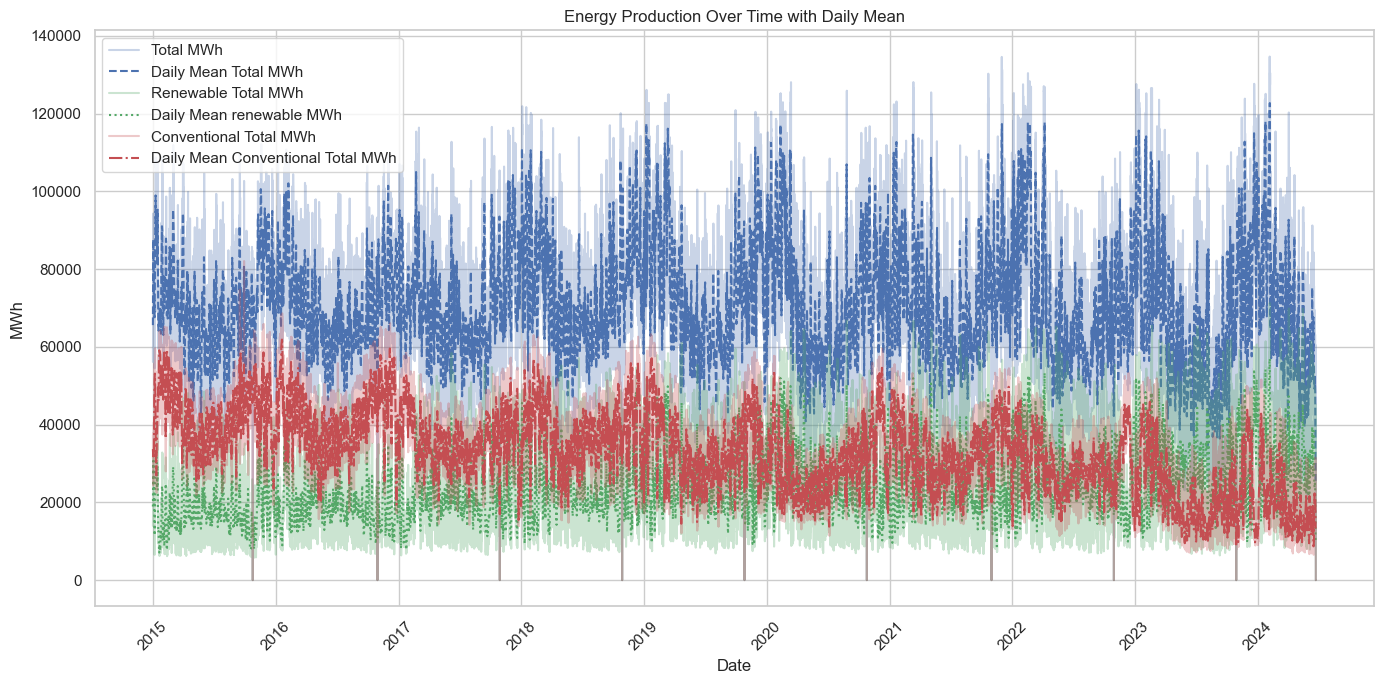

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate a daily mean for plotting
df_daily_mean = df_complete.resample('D', on='start_date').mean().reset_index()

# Setting the seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))

# Plotting total_mwh
sns.lineplot(data=df_complete, x='start_date', y='total_mwh', label='Total MWh', color='b', alpha=0.3)
sns.lineplot(data=df_daily_mean, x='start_date', y='total_mwh', label='Daily Mean Total MWh', color='b', linestyle='--')

# Plotting sum of renewables
sns.lineplot(data=df_complete, x='start_date', y='renewable_total_[mwh]', label='Renewable Total MWh', color='g', alpha=0.3)
sns.lineplot(data=df_daily_mean, x='start_date', y='renewable_total_[mwh]', label='Daily Mean renewable MWh', color='g', linestyle=':')

# Plotting sum of conventional energy
sns.lineplot(data=df_complete, x='start_date', y='conventional_total_[mwh]', label='Conventional Total MWh', color='r', alpha=0.3)
sns.lineplot(data=df_daily_mean, x='start_date', y='conventional_total_[mwh]', label='Daily Mean Conventional Total MWh', color='r', linestyle='-.')


# Enhancing the plot
plt.title('Energy Production Over Time with Daily Mean')
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
# store dataframe in data
df_complete.to_csv('../data/silver_production01.csv', index=False)